In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from fredapi import Fred
import datetime
import joblib

# Initialize FRED API
fred = Fred(api_key='8445855393be6d75a6d33bcddffc7958')


In [14]:

# Define the series IDs for the required data 
series_ids = {
    '5-Year, 5-Year Forward Inflation Expectation Rate': 'T5YIFR',
    '1 Year Treasury Rate': 'DGS1',
    'fed_balance_sheet_assets': 'WALCL',
    'gdp': 'GDP',
    'Summary of Economic Projections: Longer-Term Federal Funds Rate': 'FEDTARMDLR',
    'US 10yr': 'DGS10',
    'RRP': "WLRRAL",
    'US Treasury General Account' : 'D2WLTGAL'
}

# Fetch the data starting from 11/8/2021
start_date = '2012-01-03'

# Download data and store in a dictionary
data = {name: fred.get_series(series_id, observation_start=start_date) for name, series_id in series_ids.items()}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Resample the monthly GDP to daily frequency using forward fill method
df = df.ffill()

# Calculate the Fed Balance Sheet Assets to GDP ratio
df['Fed BS Assets to GDP'] = df['fed_balance_sheet_assets'] / (df['gdp'] * 1000)

# Calculate Net Liquidity Indicator
df['Net Liquidity Indicator'] = df['fed_balance_sheet_assets'] - df['RRP'] - df['US Treasury General Account']

# Drop unnecessary columns
df = df.drop(['fed_balance_sheet_assets', 'gdp', 'RRP', 'US Treasury General Account'], axis=1)
df = df.dropna()

In [15]:
# Calculate percent changes over various time horizons\n",
time_horizons = [5, 20, 60]
for column in df.columns:
    if column not in ['Date', 'Target']:
        df[f'{column}_pct_change_5'] = df[column].pct_change(periods=5) * 100
        df[f'{column}_pct_change_20'] = df[column].pct_change(periods=20) * 100
        df[f'{column}_pct_change_60'] = df[column].pct_change(periods=60) * 100

In [16]:
# Load the model from the file
loaded_model = joblib.load('F:/DerekS/My Projects/Python/Meeder1/US10YR_decision_tree_model.pkl')


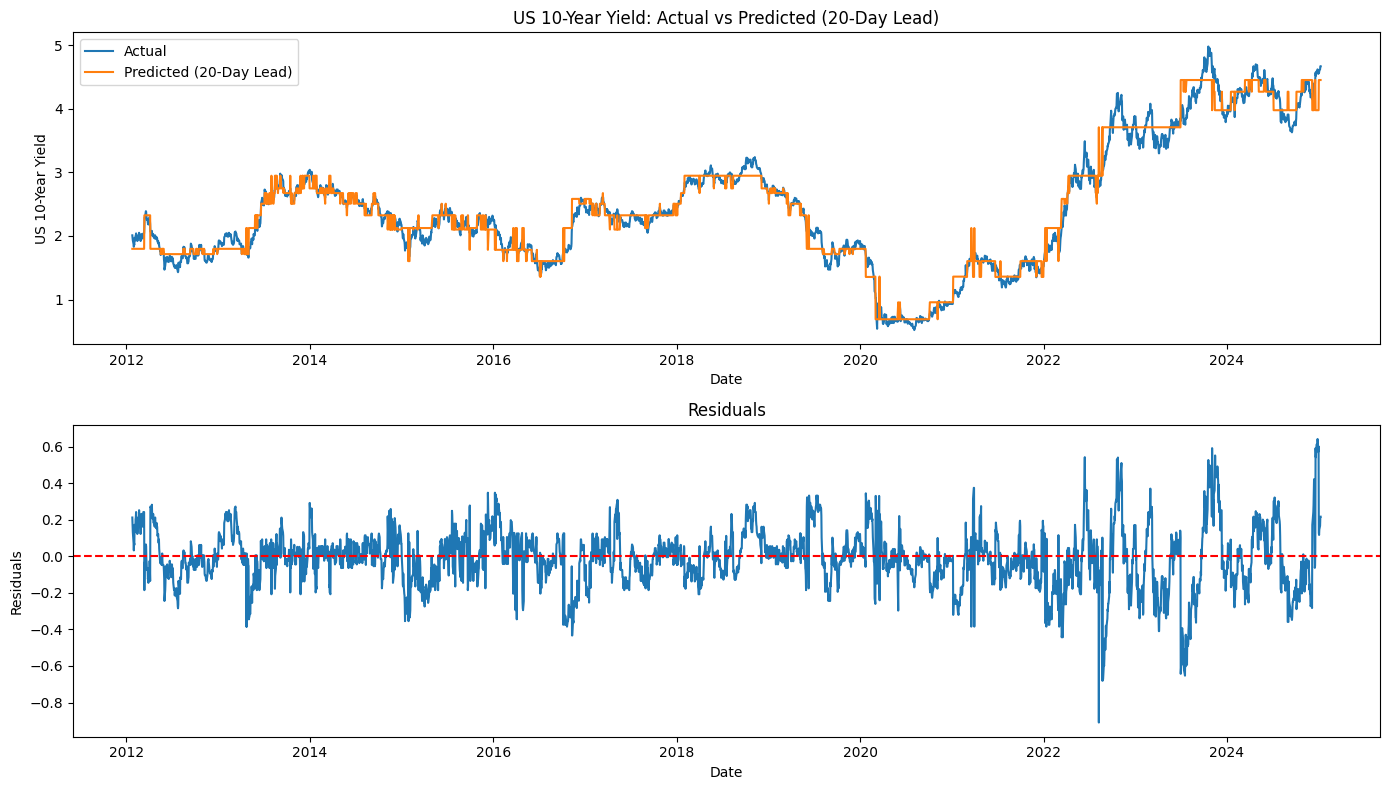

Current 10-Year Yield: 4.67
Current 10-Year Yield Prediction: 4.4529


In [17]:
X = df.copy()
# Make predictions for the entire dataset
y_pred_all = loaded_model.predict(X)


plt.figure(figsize=(14, 8))

# Plot actual vs predicted
plt.subplot(2, 1, 1)
plt.plot(X.index, X['US 10yr'], label='Actual')
plt.plot(X.index, y_pred_all, label='Predicted (20-Day Lead)')
plt.title('US 10-Year Yield: Actual vs Predicted (20-Day Lead)')
plt.xlabel('Date')
plt.ylabel('US 10-Year Yield')
plt.legend(loc = 'upper left')
plt.tight_layout()
#plt.show()
# Calculate residuals
residuals = X['US 10yr'] - y_pred_all

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(X.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()
# Retrieve the latest values
current_yield = round(X['US 10yr'].iloc[-1], 4)
current_yield_prediction = round(y_pred_all[-1], 4)
latest_diff = round(current_yield - current_yield_prediction, 4)

# Display metrics
print(f"Current 10-Year Yield: {current_yield}")
print(f"Current 10-Year Yield Prediction: {current_yield_prediction}")

In [22]:
# make predictions with alternative values
X2 = X.tail(1).copy()


c:\Users\dstockman\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


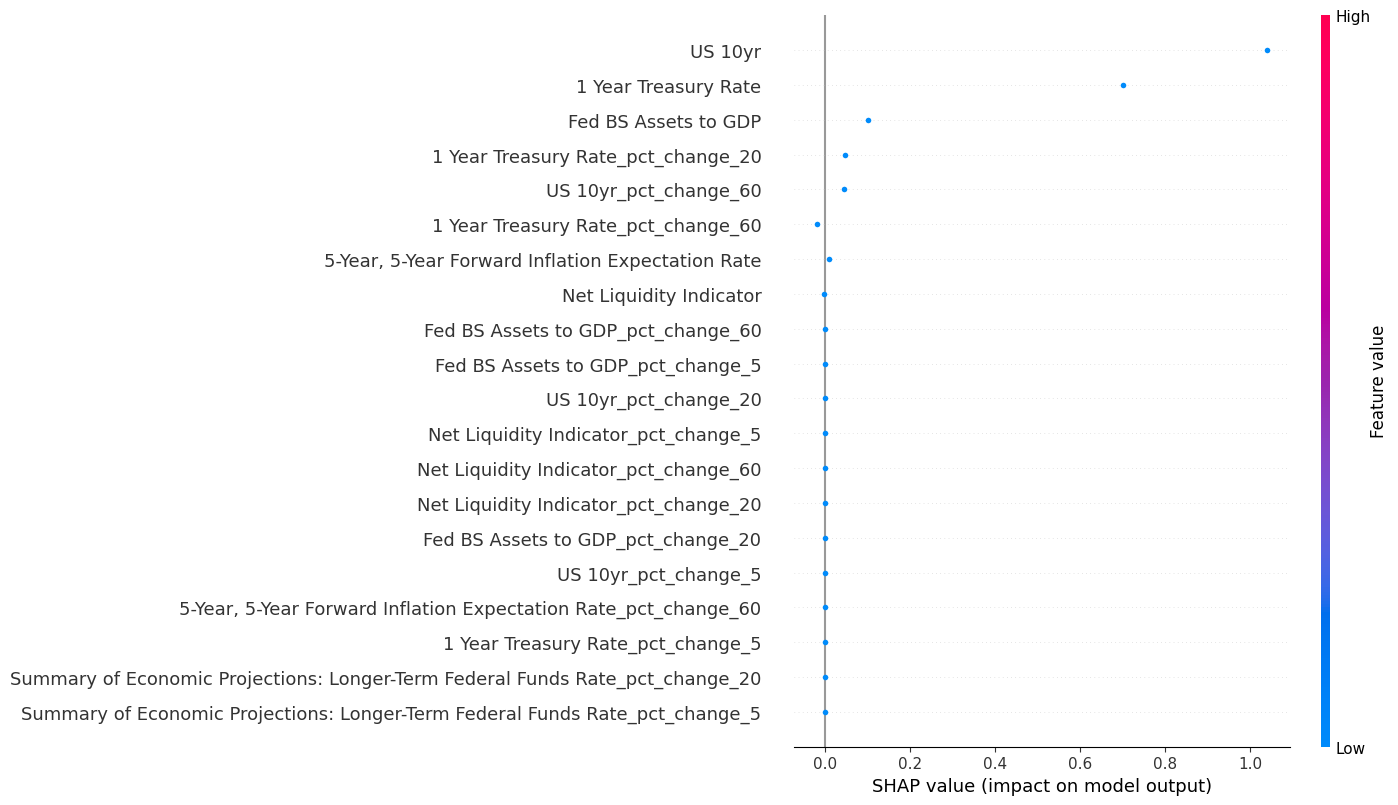

Predicted value: 1.7975746268656707
SHAP predicted value: 4.452937588342982


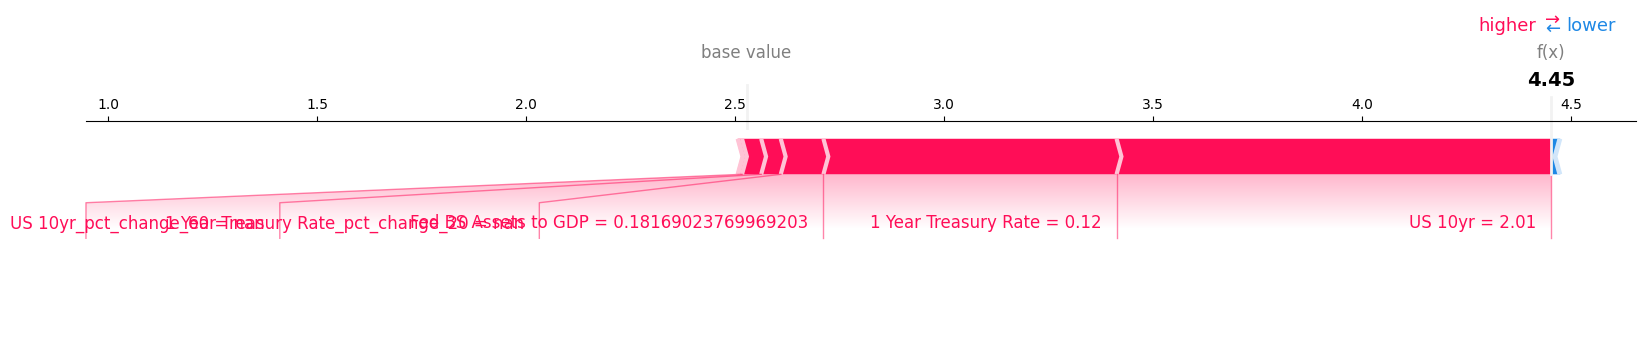

In [23]:
import shap

# Use SHAP to explain the model predictions
explainer = shap.Explainer(loaded_model, X)
shap_values = explainer(X2)

# Plot summary plot
shap.summary_plot(shap_values, X2)

# Plot SHAP values for a single prediction
#shap.force_plot(base_value=shap_values[0], features=X2.iloc[0, :], matplotlib=True)
# Plot force plot for a single prediction
#shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[0],  features=X2.iloc[0, :], matplotlib=True)
# Compare prediction and SHAP explanation for a specific instance
index = 0  # Index of the instance to compare
predicted_value = loaded_model.predict(X.iloc[index:index+1])[0]
shap_expected_value = explainer.expected_value
shap_predicted_value = shap_expected_value + shap_values[index].values.sum()

print("Predicted value:", predicted_value)
print("SHAP predicted value:", shap_predicted_value)

# Plot force plot for the specific instance
shap.force_plot(shap_expected_value, shap_values[index].values, X.iloc[index, :], matplotlib=True)